# Début d'implémentation du modèle

### Étape 0 : Importations

In [36]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F

import math
import pandas as pd

import time

from random import *
import random
from random import randrange
from random import sample 

from numpy.random import multinomial

### Étape 1 : Récupération des données

In [37]:
df = pd.read_csv("C:/Users/torna/Documents/StatApp/StatApp/data/sample1.txt",sep='\n',header=None)

### Étape 2 : Créer le vocabulaire à partir du corpus de phrases

In [38]:
df2 = df[0:1000]

corpus = []
for index, row in df2.iterrows():
    for j, column in row.iteritems():
        corpus.append(column)

In [39]:
corpus_corr = []

for phrase in corpus:
    # Suppression de la ponctuation
    phrase = phrase.replace("?","")
    phrase = phrase.replace(".","")
    phrase = phrase.replace("!","")
    phrase = phrase.replace(";","")
    phrase = phrase.replace(",","")
    phrase = phrase.replace(":","")
    phrase = phrase.replace("#","")
    # On met tout en minuscule
    phrase = phrase.lower()
    # On ajoute la phrase
    corpus_corr.append(phrase)

In [40]:
def tokenize(corpus):
    tokens = [phrase.split() for phrase in corpus]
    return tokens

t_corpus = tokenize(corpus_corr)

In [41]:
# On supprime les mentions @nicknames
corpus_ok = []
for phrase in t_corpus:
    phrase_bis = []
    for mot in phrase:
        if mot[0] == '@':
            mot = "nickname"
        phrase_bis.append(mot)
    corpus_ok.append(phrase_bis)
t_corpus = corpus_ok

In [42]:
voc = []
freqs = {}
for phrase in t_corpus:
    for mot in phrase:
        if mot not in voc:
            voc.append(mot)
            freqs[mot] = 1
        else:
            freqs[mot] +=1
voc_size = len(voc)
print(voc_size)

2904


### Étape 3 : Calcul des probas pour le subsampling et le negative sampling

In [43]:
total_mots = 0
for phrase in t_corpus:
    total_mots += len(phrase)

In [44]:
for key, value in freqs.items():
    freqs[key] = value / total_mots

In [45]:
# Probabilité d'être gardé dans le subsampling
p_sub = {word: min((math.sqrt(freqs[word]/0.001)+1)*(0.001/freqs[word]),1) for word in freqs}

In [46]:
p_neg_1 = {word: freqs[word]**(3/4) for word in freqs}
total_neg = 0
for word in p_neg_1:
    total_neg+=p_neg_1[word]
p_neg = {word: p_neg_1[word]/total_neg for word in p_neg_1}

In [47]:
def subSampling(phrase):
    phrase_samp = []
    for mot in phrase:
        if np.random.random() < (p_sub[mot]):
                phrase_samp.append(mot)
    return phrase_samp

In [48]:
mot_index = {w: index for (index, w) in enumerate(voc)}
index_mot = {index: w for (index, w) in enumerate(voc)}

### Étape 4 : Création du modèle

In [49]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show();

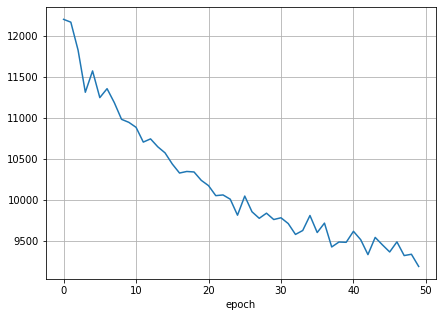

0.63


In [50]:
#Couche d'entrée
def get_input_layer(word_idx):
    x = torch.zeros(voc_size).float()
    x[word_idx] = 1.0
    return x

# Choix de dimension
embedding_dims = 10
# Initialisation
# Variable : comme Tensor mais avec les valeurs qui changent pendant le traitement
W1 = Variable(torch.randn(embedding_dims, voc_size).float(), requires_grad=True)
W2 = Variable(torch.randn(voc_size, embedding_dims).float(), requires_grad=True)
num_epochs = 50 # "époques"
learning_rate = 0.01
taille_fenetre = 5
loss_tot = []

start = time.time()
# Différentes étapes
for epo in range(num_epochs):
    loss_val = 0
    for phrase in t_corpus:
        # Sub-sampling : pour chaque phrase, on réalise le subsampling éventuel.
        phrase_samp = subSampling(phrase)
        # Ensuite, on choisit un mot focus/contexte au hasard
        
        # On crée tous les couples par phrase
        index_pairs = []
        indices = [mot_index[mot] for mot in phrase_samp]
        # On traite chaque mot comme un mot central
        for center_word in range(len(indices)):
        # Pour chaque fenetre possible
            for w in range(-taille_fenetre, taille_fenetre + 1):
                context_word = center_word + w
                # On fait attention à ne pas sauter de phrases
                if context_word < 0 or context_word >= len(indices) or center_word == context_word:
                    continue
                context_word_ind = indices[context_word]
                index_pairs.append((indices[center_word], context_word_ind))
        if len(index_pairs) > 0:
            # On en choisit une
            focus, context = choice(index_pairs)

            # Calcul loss 
            
            x = Variable(get_input_layer(focus)).float()
            y = Variable(torch.from_numpy(np.array([context])).long())
            z1 = torch.matmul(W1, x)
            z2 = torch.matmul(W2, z1)
            
            # soft max
            log_softmax = F.log_softmax(z2, dim=0)
            loss = F.nll_loss(log_softmax.view(1,-1), y)
            loss_val += loss.data

            # Propagation
            loss.backward()
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_()
            W2.grad.data.zero_()
    loss_tot.append(loss_val)
    live_plot(loss_tot)
end = time.time()
print(round((end - start)/60, 2))

In [51]:
W3 = (W1.t() + W2)/2

In [52]:
# Sauvegarder les poids - utile si traitement trop long
with open ("mat.txt", "w") as f:
    for i in range (0,len (W3)) :
        for j in range (0, len (W3[i])) :
            f.write ( str (W3[i][j]) + "\t")
        f.write ("\n")
f.close()

In [53]:
# Distance/similarité cosinus
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))

In [54]:
# Dictionnaire des poids
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(W3)}

### Étape 5 : Résultats du modèle

In [55]:
def mot_plus_proche(word, n=10):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

In [56]:
mot_plus_proche("homme")

[('arabes', 0.853344943006901),
 ('dégouté', 0.804473155499368),
 ('dégradé', 0.8033123230977118),
 ('vendre', 0.7984961263461561),
 ('soit', 0.7905719330922997),
 ('traduc', 0.7887669387123541),
 ('récent', 0.7837708511508833),
 ('disse', 0.7799726241505712),
 ('cas', 0.7795913946957914),
 ('envie', 0.7617631694898069)]

#### Données fictives - Construction fichier pour ACP

In [57]:
df_res = pd.DataFrame.from_dict(mot_poids).transpose()
df_res['label'] = 'Autre' 

df_res.loc["homme",'label'] = 'Exemple 1 Target'

for i in range(0,len(mot_plus_proche("homme"))):
    df_res.loc[mot_plus_proche("homme")[i][0],'label'] = 'Exemple 1 Contexte'

In [58]:
from sklearn.preprocessing import StandardScaler
features = [0, 1, 2, 3, 4, 5, 6, 7,8 ,9]
# Separating out the features
x = df_res.loc[:, features].values
# Separating out the target
y = df_res.loc[:,['label']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [59]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Axe 1', 'Axe 2'])

In [60]:
df_res['mot'] = df_res.index.values
df_res = df_res.reset_index()

In [61]:
finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)
#pca.explained_variance_ratio_

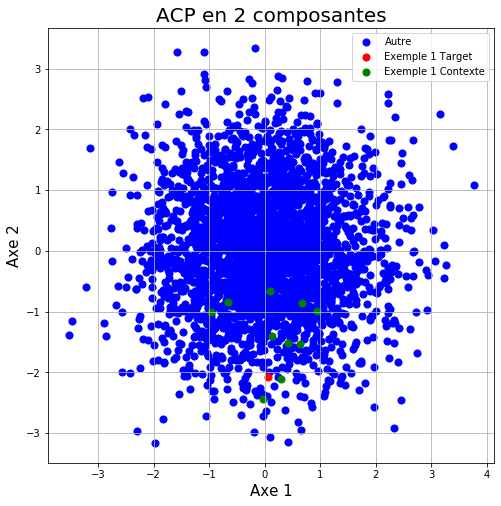

In [62]:
# Représentation simple statique 
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Axe 1', fontsize = 15)
ax.set_ylabel('Axe 2', fontsize = 15)
ax.set_title('ACP en 2 composantes', fontsize = 20)
targets = list(set(df_res['label']))
colors = ['blue', 'red', 'green', 'purple', 'pink', 'orange', 'black', 'brown', 'grey', 'magenta']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Axe 1']
               , finalDf.loc[indicesToKeep, 'Axe 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [63]:
# Représentation interactive 

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Travailler avec sous-table sinon trop lourd
subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)


subFinalDf.iplot(kind='scatter',
              mode='markers',
              x='Axe 1',
              y='Axe 2',
              categories='label',
              text='mot',
              xTitle='Axe 1',
              yTitle='Axe 2',
              title='ACP en 2 composantes',
              filename='cufflinks/simple-scatter')